# Looks at cumulative energy consumption at various time points within a study.
Is the uncertainty reasonable at each point? Looks like yes. Possibly a bit wider than needed.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt

import confusion_matrix_handling as cm_handling
from confusion_matrix_handling import MODE_MAPPING_DICT
import get_EC
import helper_functions as hf

import sklearn.model_selection as skm

from sklearn.model_selection import KFold
from sklearn import linear_model

METERS_TO_MILES = 0.000621371 # 1 meter = 0.000621371 miles
ECAR_PROPORTION = 0 #0.01 #~1% of cars on the road are electric.
DROVE_ALONE_TO_SHARED_RIDE_RATIO = 1

df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv') # r stands for raw string, only matters if the path is on Windows

In [2]:
# If you already ran store_expanded_labeled_trips.ipynb already and want to save time vs running the cell below
%store -r expanded_labeled_trips

In [ ]:
'''import database_related_functions as drf  # all the emission server functions for this notebook are in here.
user_list, os_map, uuid_program_map = drf.get_participants_programs_and_operating_systems()
#print(len(user_list), len(os_map), len(uuid_program_map))

# Takes 6 - 14 minutes for the full 1.5 year CEO dataset
# Takes ~ 1 min 45 s to 2 min 45 s on Macbook Pro for all ceo data up to May 2022.
expanded_labeled_trips = drf.get_expanded_labeled_trips(user_list)
expanded_labeled_trips['os'] = expanded_labeled_trips.user_id.map(os_map)
expanded_labeled_trips['program'] = expanded_labeled_trips['user_id'].map(uuid_program_map)

expanded_labeled_trips = expanded_labeled_trips.drop(labels = ['source', 'end_fmt_time', 'end_loc', 'raw_trip',
    'start_fmt_time', 'start_loc','start_local_dt_year', 'start_local_dt_month', 'start_local_dt_day',
    'start_local_dt_hour', 'start_local_dt_minute', 'start_local_dt_second',
    'start_local_dt_weekday', 'start_local_dt_timezone',
    'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
    'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
    'end_local_dt_weekday', 'end_local_dt_timezone'], axis = 1)

expanded_labeled_trips['distance_miles'] = expanded_labeled_trips.distance*METERS_TO_MILES

# Group together the prepilot participants
prepilot_list = ['84Q9SsrH','cwZazZLJ','CudLAeg8','sxxcLqbK','Q8T7QTXK','5KEGHHuf','e9MaNVU7','7c797MRD','rhBZukxY','k36cxmfA','FmxVf8u6','F3jxHLSW']
expanded_labeled_trips['program'] = expanded_labeled_trips.program.replace(prepilot_list, "prepilot")'''

In [22]:
unit_dist_MCS_df = pd.read_csv("unit_distance_MCS.csv").set_index("moment")
energy_dict = cm_handling.get_energy_dict(df_EI, units= 'MWH')

In [23]:
sensed_car_EI = hf.find_sensed_car_energy_intensity(energy_dict, ECAR_PROPORTION, DROVE_ALONE_TO_SHARED_RIDE_RATIO)
energy_dict.update({"Car, sensed": sensed_car_EI})
print(pd.DataFrame(energy_dict, index=[0]).transpose().round(3).to_latex())

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
Gas Car, drove alone &  0.002 \\
Gas Car, with others &  0.001 \\
E-car, drove alone   &  0.000 \\
E-car, with others   &  0.000 \\
Taxi/Uber/Lyft       &  0.002 \\
Bus                  &  0.001 \\
Free Shuttle         &  0.001 \\
Train                &  0.000 \\
Scooter share        &  0.000 \\
Pilot ebike          &  0.000 \\
Bikeshare            &  0.000 \\
Walk                 &  0.000 \\
Skate board          &  0.000 \\
Regular Bike         &  0.000 \\
Not a Trip           &  0.000 \\
No Travel            &  0.000 \\
no\_gt                &  0.000 \\
Car, sensed          &  0.001 \\
\bottomrule
\end{tabular}



In [24]:
# Drop trips you want to exclude from analysis.
expanded_labeled_trips = hf.drop_unwanted_trips(expanded_labeled_trips, drop_not_a_trip=False)

# Find the primary mode - the sensed mode with the longest section for each trip.
expanded_labeled_trips = hf.get_primary_modes(expanded_labeled_trips,energy_dict,MODE_MAPPING_DICT)

print('Here are the number of labeled trips remaining in each program dataset:')
expanded_labeled_trips.program.value_counts()

Dropping user labeled AIR trips and trips with no OS.
Dropped 0 trips with no sensed sections.
Here are the number of labeled trips remaining in each program dataset:


cc          28768
pc          17880
fc          11744
stage       10715
sc           9092
vail         6348
4c           5262
prepilot     2425
Name: program, dtype: int64

In [6]:
# Get the confusion matrices and then the EI moments from those.
android_confusion = pd.read_csv("android_confusion.csv").set_index('gt_mode')
ios_confusion = pd.read_csv("ios_confusion.csv").set_index('gt_mode')

android_confusion = cm_handling.collapse_confusion_matrix(android_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})
ios_confusion = cm_handling.collapse_confusion_matrix(ios_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})

# here I'm referring to car_load_factor the number that we divide the drove alone energy intensity by
# for r = 1, car_load_factor is 4/3.
sensed_car_EI = hf.find_sensed_car_energy_intensity(energy_dict, ECAR_PROPORTION, DROVE_ALONE_TO_SHARED_RIDE_RATIO)
energy_dict.update({"Car, sensed": sensed_car_EI})

EI_length_cov = 0

In [7]:
# if you forget this step, the error for expected may be different, 
# since you might be relying on a different saved version of the EI_moments_dataframe
android_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(android_confusion,energy_dict)
ios_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(ios_confusion,energy_dict)
os_EI_moments_map = {'ios': ios_EI_moments_df, 'android': android_EI_moments_df}
energy_consumption_df = get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,android_EI_moments_df,ios_EI_moments_df, \
    EI_length_cov, print_info=False)

Computing energy consumption for each trip.
Using EI length covariance = 0.


In [8]:
energy_errors = energy_consumption_df.expected - energy_consumption_df.user_labeled
var_estimate = np.var(energy_errors, ddof=1)*len(expanded_labeled_trips)
sd = np.sqrt(var_estimate)

propagated_var, _ = get_EC.compute_aggregate_variance_with_total_distance_from_sections(energy_consumption_df,os_EI_moments_map, unit_dist_MCS_df)
print(f"propagated var, residual var: {np.sqrt(propagated_var):.2f}, {sd:.2f}")

propagated var, residual var: 170.98, 4.38


In [9]:
# what's the residual variance when we compare user labeled with predicted energy consumption?
energy_prediction_errors = energy_consumption_df.predicted - energy_consumption_df.user_labeled
var_estimate = np.var(energy_prediction_errors, ddof=1)*len(expanded_labeled_trips)
sd_prediction_error = np.sqrt(var_estimate)
sd_prediction_error

4.567450658518725

### Sensitivity Analysis: vary the time of the final trip in the dataset

In [20]:
MONTH_IN_SECONDS = 30*3600*24

def get_cumulative_EC_lists(df, os_EI_moments_map, unit_dist_MCS_df):

    df = df.copy()
    start_time = df.start_ts.min()
    stop_time = df.end_ts.max()

    time_array = np.linspace(start_time + MONTH_IN_SECONDS, stop_time, num= 30)

    user_labeled_EC_list = []
    expected_EC_list = []
    standard_deviation_list = []
    user_sd_list = []

    for t in time_array:
        sub_df = df[df.end_ts < t]
        # get energy consumption mean and variance for user labeled and for sensed as lists
        expected_EC_list.append(sub_df.expected.sum())
        user_labeled_EC_list.append(sub_df.user_labeled.sum())

        # Beware: this function currently returns two things
        EC_var, _ = get_EC.compute_aggregate_variance_with_total_distance_from_sections(sub_df, os_EI_moments_map,unit_dist_MCS_df)
        standard_deviation_list.append(np.sqrt(EC_var))
        user_sd_list.append(np.sqrt(sub_df.user_var.sum()))

    return expected_EC_list, user_labeled_EC_list, standard_deviation_list, user_sd_list, time_array

def plot_cumulative_EC(program, expected_EC_list, user_labeled_EC_list, standard_deviation_list, user_sd_list, time_array):
    label_font_size = 15
    plt.scatter(time_array, expected_EC_list, marker= '.', c= 'tab:orange', s = 200)
    plt.scatter(time_array, np.array(expected_EC_list) - np.array(standard_deviation_list), marker= '_', c = 'tab:orange', s = 200)
    plt.scatter(time_array, np.array(expected_EC_list) + np.array(standard_deviation_list), marker= '_', c = 'tab:orange', s = 200)
    plt.scatter(time_array, user_labeled_EC_list, marker= '.', c= 'tab:blue', s = 200)
    plt.xlabel("Timestamp", fontsize=label_font_size)
    plt.ylabel("Cumulative energy consumption (MWH)", fontsize=label_font_size)
    plt.title(f"Cumulative energy consumption over time with uncertainty for {program}", fontsize = label_font_size)
    plt.rcParams["figure.figsize"] = (10,10)
    plt.show()


In [9]:
cc_expected, cc_user_labeled, cc_sensed_sd, cc_user_sd, cc_time_array = get_cumulative_EC_lists(energy_consumption_df[energy_consumption_df.program == 'cc'], os_EI_moments_map, unit_dist_MCS_df)

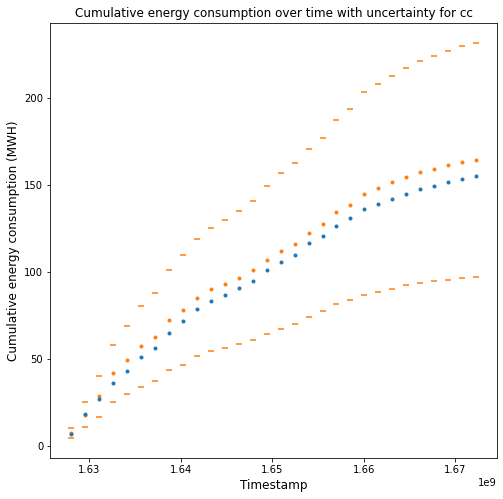

In [13]:
plot_cumulative_EC("cc", cc_expected, cc_user_labeled, cc_sensed_sd, cc_user_sd, cc_time_array)

In [10]:
pc_expected, pc_user_labeled, pc_sensed_sd, pc_user_sd, pc_time_array = get_cumulative_EC_lists(energy_consumption_df[energy_consumption_df.program == "pc"], os_EI_moments_map, unit_dist_MCS_df)

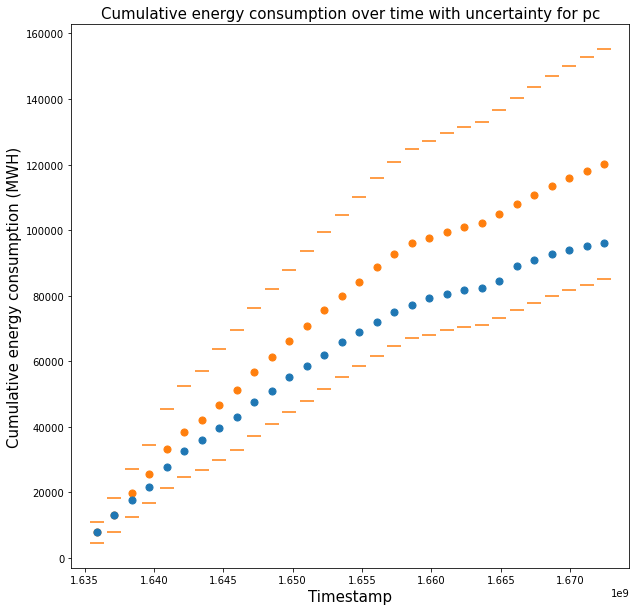

In [21]:
plot_cumulative_EC("pc", pc_expected, pc_user_labeled, pc_sensed_sd, pc_user_sd, pc_time_array)

In [11]:
# get the error for cumulative energy consumption over time for each user. Takes ~2 min 40 s
sd_df = pd.DataFrame()
all_sd_array = np.array([])
i = 0
for user in energy_consumption_df.user_id.unique():
    user_df = energy_consumption_df[energy_consumption_df.user_id == user]
    expected_EC_list, user_labeled_EC_list, standard_deviation_list, user_sd_list, time_array = get_cumulative_EC_lists(user_df, os_EI_moments_map, unit_dist_MCS_df)

    n_sd = (np.array(expected_EC_list) - np.array(user_labeled_EC_list))/np.array(standard_deviation_list)
    sd_df[f"{len(user_df)}-{i}"] = n_sd
    i +=1

    all_sd_array = np.concatenate((all_sd_array, n_sd))


/opt/anaconda3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [39]:
sd_df

,364-0,127-1,575-2,1505-3,951-4,14-5,1446-6,1153-7,91-8,544-9,...,212-225,217-226,33-227,163-228,81-229,380-230,264-231,208-232,22-233,618-234
0,3.075125,0.719034,0.327790,-0.494147,-0.012646,-1.060414,0.409574,2.276262,-6.707398,1.147994,...,-0.318303,0.630975,1.464565,-0.135517,-6.423461,1.311380,-1.667258,0.780954,4.151162,2.101627
1,1.584854,0.719034,0.217222,-0.271850,0.077994,-1.060414,0.301734,2.276262,-7.102329,1.185939,...,-0.318303,0.610309,-0.169152,-0.140938,-6.423461,1.310080,-1.260175,0.691426,4.151162,2.043775
2,1.593397,0.719034,0.420259,-0.248897,-0.018908,-1.060414,-0.181063,2.276262,-7.102329,1.190921,...,-0.318303,0.585631,-0.052261,-0.133354,-6.423461,0.587857,-1.274094,0.774434,4.151162,2.064157
3,1.593423,0.719034,0.480294,-0.013671,-0.018908,-1.060414,-0.192812,2.316391,-7.957398,1.300186,...,-0.318303,1.696241,-0.052261,-0.113016,-6.423461,0.735819,-1.274094,0.818426,4.151162,1.994493
4,1.851864,0.719034,0.538632,0.052104,-0.018908,-1.060414,-0.221192,2.316391,-6.140136,1.300912,...,-0.086009,1.653628,-0.052261,-0.070854,-6.423461,0.676402,-1.267680,0.810045,4.151162,2.060684
5,1.864068,0.719034,0.686109,0.123392,-0.018908,-1.060414,-0.210455,2.312578,-5.943852,1.307562,...,0.027878,1.608378,-0.052261,-0.048498,-6.423461,0.753076,-1.200186,0.810045,4.151162,2.107098
6,1.907192,0.719034,0.760097,0.159465,-0.018908,-1.060414,-0.233044,2.996762,-6.667137,1.274742,...,0.166542,1.502797,-0.052261,-0.028089,-0.676204,0.776119,-1.186017,0.928069,4.151162,2.181019
7,1.916603,0.719034,0.747127,0.209494,-0.018908,-1.060414,-0.236120,2.383024,-6.951144,1.254243,...,0.052722,1.464915,-0.052261,0.020324,-0.906840,0.854729,-1.253279,0.928069,4.151162,2.238133
8,1.955166,0.719034,0.856136,0.193276,-0.018908,-1.060414,-0.236923,2.268206,-7.186273,1.247277,...,0.196205,1.426749,-0.052261,0.071448,-0.899676,0.750181,-1.258105,0.853270,4.151162,2.273014
9,1.955166,0.719034,0.867476,0.182523,-0.018908,-1.060414,-0.232805,2.166945,-7.186273,1.247467,...,0.275678,1.387468,-0.107220,0.065368,-0.899416,0.777243,-1.093983,0.832474,4.151162,2.267373


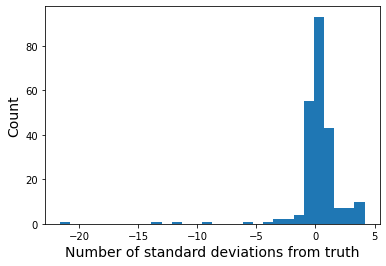

In [27]:
plt.hist(sd_df.iloc[29,], bins=30)
plt.xlabel("Number of standard deviations from truth", fontsize= 14)
plt.ylabel("Count",fontsize= 14)
plt.show() 


In [21]:
# Looking at the mode share of users for which the uncertainty does not capture the truth as well.
i = 0
for u in energy_consumption_df.user_id.unique():
    # look at last row
    if (sd_df.iloc[29,i] < -5) or (sd_df.iloc[29,i] > 3):
        user_df = energy_consumption_df[energy_consumption_df.user_id == u]
        print(f"n sd at the end: {sd_df.iloc[29,i]:.3f}")
        hf.print_top_mode_confirm_proportions(user_df)
    i += 1

n sd at the end: 2.664
\begin{tabular}{lr}
\toprule
{} &  distance\_miles \\
mode\_confirm &                 \\
\midrule
pilot\_ebike  &          0.6883 \\
shared\_ride  &          0.2350 \\
walk         &          0.0326 \\
drove\_alone  &          0.0160 \\
bike         &          0.0143 \\
taxi         &          0.0137 \\
\bottomrule
\end{tabular}

n sd at the end: -3.721
\begin{tabular}{lr}
\toprule
{} &  distance\_miles \\
mode\_confirm &                 \\
\midrule
drove\_alone  &          0.4653 \\
shared\_ride  &          0.3945 \\
not\_a\_trip   &          0.1166 \\
ride         &          0.0236 \\
\bottomrule
\end{tabular}

n sd at the end: 3.629
\begin{tabular}{lr}
\toprule
{} &  distance\_miles \\
mode\_confirm &                 \\
\midrule
walk         &          0.7167 \\
bike         &          0.2833 \\
\bottomrule
\end{tabular}

n sd at the end: 3.606
\begin{tabular}{lr}
\toprule
{} &  distance\_miles \\
mode\_confirm &                 \\
\midrule
walk         &     

In [51]:
user_df.groupby('mode_confirm').distance.sum()/user_df.distance.sum()  # from sc
# this persons set of trips falls outside of our assumptions 
#   - none of their labeled trips were ebike and they drove alone more than they rode with others

mode_confirm
drove_alone    0.465324
not_a_trip     0.116590
ride           0.023555
shared_ride    0.394532
Name: distance, dtype: float64

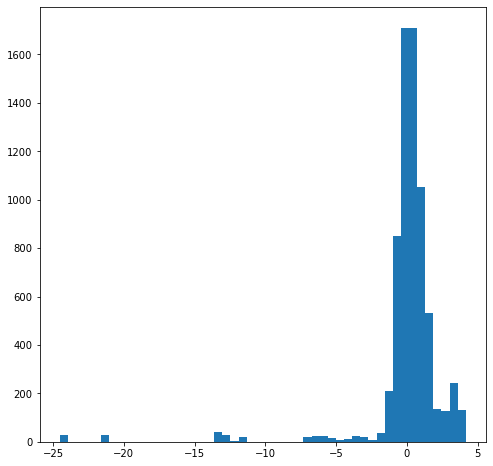

In [41]:
plt.hist(all_sd_array, bins=50); plt.show()

In [ ]:
# wait a minute - Chebychev's inequality is for 1 distribution with 1 standard deviation.
# Each estimate we come up with has its own standard deviation.

In [28]:
# how are the number of standard deviations distributed for each participant's full set of trips?
for j in [1,2,3,4, 5, 6]:
    users_full_study_sd = sd_df.iloc[-1]
    print(f"Percent within {j} sd: {100*sum(abs(users_full_study_sd)<j) /len(users_full_study_sd):.2f}") 
    

Percent within 1 sd: 71.91
Percent within 2 sd: 85.53
Percent within 3 sd: 88.94
Percent within 4 sd: 94.89
Percent within 5 sd: 95.32
Percent within 6 sd: 95.74


In [57]:
users_full_study_sd = sd_df.iloc[-1]
len(users_full_study_sd)

235

In [30]:
available_ground_truth_modes

Index(['Walk', 'Regular Bike', 'Pilot ebike', 'Scooter share', 'Car, sensed',
       'Bus', 'no_gt', 'Train'],
      dtype='object', name='gt_mode')

In [14]:
available_ground_truth_modes = android_confusion.index
uniform_prior = hf.construct_prior_dict({},available_ground_truth_modes)

android_EI_moments_with_Bayes_update_df = cm_handling.get_Bayesian_conditional_EI_expectation_and_variance(android_confusion,energy_dict, uniform_prior)
ios_EI_moments_with_Bayes_update_df = cm_handling.get_Bayesian_conditional_EI_expectation_and_variance(ios_confusion,energy_dict, uniform_prior)
os_EI_moments_with_Bayes_update_map = {'ios': ios_EI_moments_with_Bayes_update_df, 'android': android_EI_moments_with_Bayes_update_df}
energy_consumption_with_Bayes_update_df = get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,\
    android_EI_moments_with_Bayes_update_df,\
    ios_EI_moments_with_Bayes_update_df, \
    EI_length_cov, print_info=False)

Computing energy consumption for each trip.
Using EI length covariance = 0.


In [ ]:
sd_df_unif = pd.DataFrame()
all_sd_array_unif = np.array([])
i = 0
for user in energy_consumption_df.user_id.unique():
    user_df = energy_consumption_with_Bayes_update_df[energy_consumption_with_Bayes_update_df.user_id == user]
    expected_EC_list, user_labeled_EC_list, standard_deviation_list, user_sd_list, time_array = get_cumulative_EC_lists(user_df, os_EI_moments_map, unit_dist_MCS_df)

    n_sd = (np.array(expected_EC_list) - np.array(user_labeled_EC_list))/np.array(standard_deviation_list)
    sd_df_unif[f"{len(user_df)}-{i}"] = n_sd
    i +=1

    all_sd_array_unif = np.concatenate((all_sd_array_unif, n_sd))

# gives a few warning messages but works for most users.

In [61]:
for j in [1,2,3,4, 5, 6]:
    users_full_study_sd = sd_df_unif.iloc[-1]
    print(f"Percent within {j} sd: {100*sum(abs(users_full_study_sd)<j) /len(users_full_study_sd):.2f}")

Percent within 1 sd: 70.64
Percent within 2 sd: 85.96
Percent within 3 sd: 88.94
Percent within 4 sd: 94.89
Percent within 5 sd: 95.32
Percent within 6 sd: 95.74


In [62]:
for j in [1,2,3,4, 5, 6]:
    print(f"Percent within {j} sd: {100*sum(abs(all_sd_array_unif)<j) /len(all_sd_array_unif):.2f}")

Percent within 1 sd: 68.47
Percent within 2 sd: 87.48
Percent within 3 sd: 90.70
Percent within 4 sd: 95.90
Percent within 5 sd: 96.92
Percent within 6 sd: 97.38


In [64]:
total_sd = np.sqrt(
    get_EC.compute_aggregate_variance_with_total_distance_from_sections(
    energy_consumption_df,
    os_EI_moments_map,
    unit_dist_MCS_df)[0]
)

# our 1 sd upper bound vs all car trips upper bound
# Definitely a tighter upper bound.
sum(energy_consumption_df.expected) + total_sd, energy_consumption_df.distance_miles.sum()*1.5*10e-3

(684.8254394217316, 7790.34790883269)

In [44]:
available_ground_truth_modes = android_confusion.index
car_prior = hf.construct_prior_dict({"Pilot ebike": 0, "Car, sensed": 0.8}, available_ground_truth_modes)

android_EI_moments_with_Bayes_update_df = cm_handling.get_Bayesian_conditional_EI_expectation_and_variance(android_confusion,energy_dict, car_prior)
ios_EI_moments_with_Bayes_update_df = cm_handling.get_Bayesian_conditional_EI_expectation_and_variance(ios_confusion,energy_dict, car_prior)
os_EI_moments_with_Bayes_update_map = {'ios': ios_EI_moments_with_Bayes_update_df, 'android': android_EI_moments_with_Bayes_update_df}
energy_consumption_with_Bayes_update_df = get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,\
    android_EI_moments_with_Bayes_update_df,\
    ios_EI_moments_with_Bayes_update_df, \
    EI_length_cov, print_info=False)

Computing energy consumption for each trip.
Using EI length covariance = 0.


In [45]:
sd_df_car = pd.DataFrame()
all_sd_array_car = np.array([])
i = 0
for user in energy_consumption_df.user_id.unique():
    if (i == 8):
        user_df = energy_consumption_with_Bayes_update_df[energy_consumption_with_Bayes_update_df.user_id == user]
        expected_EC_list, user_labeled_EC_list, standard_deviation_list, user_sd_list, time_array = get_cumulative_EC_lists(user_df, os_EI_moments_map, unit_dist_MCS_df)

        n_sd = (np.array(expected_EC_list) - np.array(user_labeled_EC_list))/np.array(standard_deviation_list)
        sd_df_car[f"{len(user_df)}-{i}"] = n_sd
    i +=1

    all_sd_array_car = np.concatenate((all_sd_array_unif, n_sd))

In [47]:
car_prior

{'Pilot ebike': 0,
 'Car, sensed': 0.8,
 'Walk': 0.033333333333333326,
 'Regular Bike': 0.033333333333333326,
 'Scooter share': 0.033333333333333326,
 'Bus': 0.033333333333333326,
 'no_gt': 0.033333333333333326,
 'Train': 0.033333333333333326}